# Importing the Required Libraries

In [105]:
import pandas as pd
import os
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, KNNWithMeans, accuracy
from surprise.model_selection import cross_validate, train_test_split
sns.set_style("darkgrid")

Understanding the quantity of data ( Skipping the Date Column)

In [3]:

df1 = pd.read_csv('D:\\My Works\\Netflix Recommendation System\\Dataset\\combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1.dtypes

Cust_Id     object
Rating     float64
dtype: object

In [4]:
df1.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [5]:
df1.shape

(24058263, 2)

In [6]:
print(df1.iloc[::2500000, :])

          Cust_Id  Rating
0              1:     NaN
2500000   2560487     4.0
5000000   2560324     4.0
7500000   2297074     3.0
10000000  2271935     2.0
12500000  2076253     3.0
15000000  1921803     2.0
17500000  1127091     4.0
20000000  1933327     3.0
22500000  1646238     5.0


Combining all 4 Datasets into a sinle Dataframe

In [7]:
df2 = pd.read_csv('D:\\My Works\\Netflix Recommendation System\\Dataset\\combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('D:\\My Works\\Netflix Recommendation System\\Dataset\\combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('D:\\My Works\\Netflix Recommendation System\\Dataset\\combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df = df1
df = df1.append(df2)
df = df.append(df3)
df = df.append(df4)


In [8]:

df.index = np.arange(0,len(df))
print(df.iloc[::10000000, :])

           Cust_Id  Rating
0               1:     NaN
10000000   2271935     2.0
20000000   1933327     3.0
30000000    961023     4.0
40000000    854274     5.0
50000000    768483     3.0
60000000   1609324     2.0
70000000   1776418     4.0
80000000    932047     4.0
90000000    932191     4.0
100000000   872339     4.0


## Data Visualization

Getting Movie Counts, Rating Counts and User Counts

In [10]:
p = df.groupby('Rating')['Rating'].agg(['count'])

movie_count = df.isnull().sum()[1]

cust_count = df['Cust_Id'].nunique() - movie_count

rating_count = df['Cust_Id'].count() - movie_count



Visualizing the whole data in a horizontal bar diagram

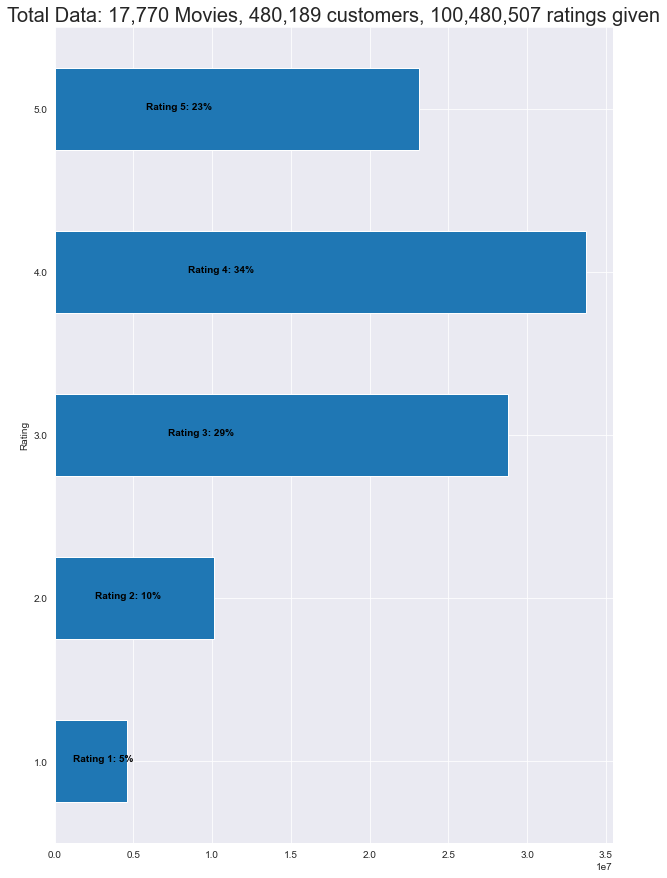

In [12]:
ax = p.plot(kind = 'barh', legend = False, figsize = (10,15))
plt.title('Total Data: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'black', weight = 'bold')



Outhere, we can see that the ratings are tend to be more positive. This doesn't mean that the feature films in the platforms are mostly good. As i can understand this, people tend to rate the film mostly if it is particularly good

## Data Modification


We are creating a new column named Movie ID for the sake of construction of recommendation system. Outhere we can't loop it till the end due to its size. So we will use the numpy approach

In [13]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 1.777e+04 1.777e+04 1.777e+04]
Length: 100480507


In [14]:

# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])


-Dataset examples-
           Cust_Id  Rating  Movie_Id
1          1488844     3.0         1
5000996     501954     2.0       996
10001962    404654     5.0      1962
15002876    886608     2.0      2876
20003825   1193835     2.0      3825
25004661   1899206     3.0      4661
30005496    154804     4.0      5496
35006274   2078749     5.0      6274
40007057    450763     5.0      7057
45007991    102092     3.0      7991
50009023    220298     5.0      9023
55010042    550530     5.0     10042
60011038    222570     3.0     11038
65011875   1273080     5.0     11875
70012676   2026970     5.0     12676
75013582    506044     4.0     13582
80014453    353605     2.0     14453
85015116    664606     3.0     15116
90016008   2213715     3.0     16008
95016879   1589401     5.0     16879
100017627  2314006     4.0     17627


## Data Reduction

The data is now in cleaned and modified according to the convenience. But still the data is still super huge . So we have to reduce it without compromising much on the quality. So i decided to eliminate the less active users and less popular movies from the data. I used the basic concept of 'mean' and 'quantile' for this purpose

In [15]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1948.0
Customer minimum times of review: 211.0


Now we get into a conclusion that except the above mentioned movies and users, the rest of them are 'short times' or doesn't have much impact on the generalization factor. By removing these , we could also boost the efficiency

In [16]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (100480507, 3)
After Trim Shape: (71833509, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6959351   1973032     4.0      1395
13901827   412139     5.0      2660
20826547  1503396     4.0      3925
27788420  2417320     2.0      5121
34830730  2551271     5.0      6240
41872703  2406150     4.0      7399
48692662  1305391     2.0      8782
55551262   528496     3.0     10158
62650465   599678     2.0     11376
69655550   964493     5.0     12612
76741354   829466     5.0     13923
83765399  2255251     4.0     14953
90860581  1097827     4.0     16169
97938791  1463885     5.0     17321


Now we are going to Pivot the Dataframe for making the Model Based Collaberative Recommendation System

In [17]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

# Below is another way I used to sparse the dataframe...doesn't seem to work better

#Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
#Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
#data = df['Rating'].tolist()
#row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
#col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
#df_p = df_p.replace(0, np.NaN)


(144380, 5332)


## Data mapping

Now we will use the mapping file available in the data to replace name with movie ID column

In [18]:
df_title = pd.read_csv('D:\\My Works\\Netflix Recommendation System\\movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


In [19]:
df.shape

(71833509, 3)

In [20]:
df.head()

,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


# Recommendation models

Now, all the data is been cleaned and modified for constructing the recommendation system

## 1) Model Based Recommendation System

We are ready to construct a recommendation system and at first we would be framing an item-item, user-user recommendation system(Collaborative Filtering) 

In [23]:
reader = Reader()

data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([1.00254907, 1.00154605, 0.98941065, 0.99548491, 0.9996524 ]),
 'test_mae': array([0.79853881, 0.79733593, 0.79219048, 0.796048  , 0.79450093]),
 'fit_time': (4.027758836746216,
  4.128763437271118,
  4.084498405456543,
  4.141396999359131,
  4.054544925689697),
 'test_time': (0.0909428596496582,
  0.09873676300048828,
  0.10187077522277832,
  0.09943437576293945,
  0.15335559844970703)}

Lets consider a random customer, say 712664. Now at first we are going to understand the taste of this customer on this domain by analyzing his past activities

In [59]:
df_712664 = df[(df['Cust_Id'] == 712664) & (df['Rating'] == 5)]
df_712664 = df_712664.set_index('Movie_Id')
df_712664 = df_712664.join(df_title)['Name']
print(df_712664)

Movie_Id
3                                        Character
79                                     The Killing
175                                 Reservoir Dogs
199                                The Deer Hunter
241                             North by Northwest
                           ...                    
17560                                 Ghostbusters
17578                          Reversal of Fortune
17589                                     The Cell
17591    Dr. Seuss' How the Grinch Stole Christmas
17619                              Out of the Past
Name: Name, Length: 412, dtype: object


Lets make a recommendation system based on user-user similarity. Here we are going to predict some feature films for customer 712664 based on his past activities

In [60]:
user_712664 = df_title.copy()
user_712664 = user_712664.reset_index()
user_712664 = user_712664[~user_712664['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_712664['Estimate_Score'] = user_712664['Movie_Id'].apply(lambda x: svd.predict(712664, x).est)

user_712664 = user_712664.drop('Movie_Id', axis = 1)

user_712664 = user_712664.sort_values('Estimate_Score', ascending=False)
print(user_712664.head(10))


         Year                        Name  Estimate_Score
2      1997.0                   Character        4.169960
7      2004.0  What the #$*! Do We Know!?        3.718862
15     1996.0                   Screamers        3.165854
16     2005.0                   7 Seconds        2.824775
17     1994.0            Immortal Beloved        3.897567
...       ...                         ...             ...
17760  2003.0                      Levity        3.747034
17761  1997.0                     Gattaca        3.747034
17762  1978.0                   Interiors        3.747034
17763  1998.0         Shakespeare in Love        3.747034
17768  2003.0                 The Company        3.747034

[5332 rows x 3 columns]


## Recommendation based on Popularity

Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up. As you can see , the recommendation or the content is not personalised but still this recommendation is blended in the hybrid version by many giants.

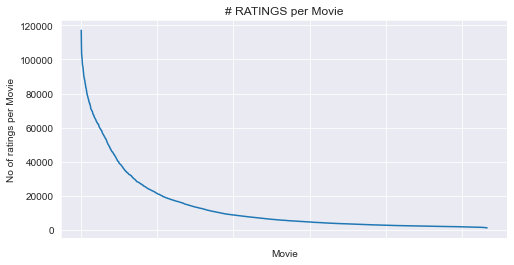

In [36]:
no_of_ratings_per_movie = df.groupby(by='Movie_Id')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of ratings per Movie')
ax.set_xticklabels([])

plt.show()

In [38]:
df.groupby('Movie_Id')['Rating'].mean().head()

Movie_Id
3     3.620228
8     3.140967
16    3.080652
17    2.914113
18    3.768554
Name: Rating, dtype: float64

In [74]:
lar_rating_mean=df.groupby('Movie_Id')['Rating'].mean().sort_values(ascending=False)
lar_rating_mean=lar_rating_mean.to_frame() 
print(lar_rating_mean)

            Rating
Movie_Id          
14961     4.716273
7230      4.710813
7057      4.696930
3456      4.664190
2102      4.588516
...            ...
8489      2.074835
3021      1.963604
13607     1.945808
12517     1.943105
15044     1.863087

[5332 rows x 1 columns]


In [73]:

lar_rating_mean = lar_rating_mean.join(df_title)['Name']
print(lar_rating_mean)


Movie_Id
14961    Lord of the Rings: The Return of the King: Ext...
7230     The Lord of the Rings: The Fellowship of the R...
7057     Lord of the Rings: The Two Towers: Extended Ed...
3456                                        Lost: Season 1
2102                                The Simpsons: Season 6
                               ...                        
8489                                       The Brown Bunny
3021                                     House of the Dead
13607                           Stop! Or My Mom Will Shoot
12517                                                Gigli
15044                                              Glitter
Name: Name, Length: 5332, dtype: object


As you can see outhere, these are the best rated features in our dataset and these would be useful when we are building a hybrid recommendation model.

In [75]:
ratings_mean_count = pd.DataFrame(df.groupby('Movie_Id')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(df.groupby('Movie_Id')['Rating'].count())
ratings_mean_count.head()

,Rating,rating_counts
Movie_Id,,
3,3.620228,1493
8,3.140967,9222
16,3.080652,2517
17,2.914113,4145
18,3.768554,9432


In [76]:
ratings_mean_count['rating_counts'].max()

117148

In [77]:
ratings_mean_count['rating_counts'].min()

1121

<AxesSubplot:>

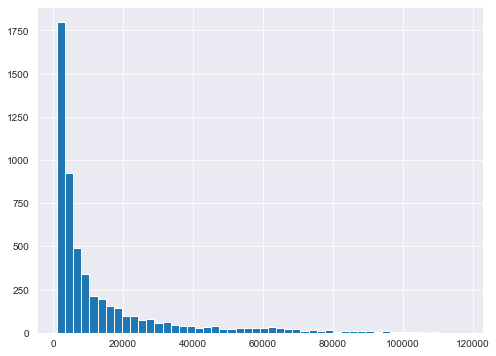

In [78]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

In [86]:
popular_movies = pd.DataFrame(df.groupby('Movie_Id')['Rating'].count())
most_popular = popular_movies.sort_values('Rating', ascending=False)
print(most_popular)


          Rating
Movie_Id        
1905      117148
11283     110135
15124     109636
15107     106978
5317      105124
...          ...
17096       1195
761         1187
9044        1184
717         1182
11819       1121

[5332 rows x 1 columns]


In [87]:
most_popular_fig=most_popular

In [88]:
most_popular = most_popular.join(df_title)['Name']
print(most_popular)

Movie_Id
1905     Pirates of the Caribbean: The Curse of the Bla...
11283                                         Forrest Gump
15124                                     Independence Day
15107                                       Ocean's Eleven
5317                                     Miss Congeniality
                               ...                        
17096                         Carlito's Way: Rise to Power
761                                             O Fantasma
9044                                                 Fidel
717                                           Testosterone
11819                                            Locked Up
Name: Name, Length: 5332, dtype: object


In [89]:
most_popular.head(30)

Movie_Id
1905     Pirates of the Caribbean: The Curse of the Bla...
11283                                         Forrest Gump
15124                                     Independence Day
15107                                       Ocean's Eleven
5317                                     Miss Congeniality
4306                                       The Sixth Sense
2452         Lord of the Rings: The Fellowship of the Ring
571                                        American Beauty
14691                                           The Matrix
11521                    Lord of the Rings: The Two Towers
6037                                   The Bourne Identity
13728                                            Gladiator
6287                                          Pretty Woman
11064                                         Pulp Fiction
3860                                        Bruce Almighty
14410                                           Spider-Man
6206                              My Big Fat Gr

In [92]:
most_popular_fig['Movie_Name']=most_popular
print(most_popular_fig)

          Rating                                         Movie_Name
Movie_Id                                                           
1905      117148  Pirates of the Caribbean: The Curse of the Bla...
11283     110135                                       Forrest Gump
15124     109636                                   Independence Day
15107     106978                                     Ocean's Eleven
5317      105124                                  Miss Congeniality
...          ...                                                ...
17096       1195                       Carlito's Way: Rise to Power
761         1187                                         O Fantasma
9044        1184                                              Fidel
717         1182                                       Testosterone
11819       1121                                          Locked Up

[5332 rows x 2 columns]


In [98]:
most_popular_fig= most_popular_fig.set_index('Movie_Name')

<AxesSubplot:xlabel='Movie_Name'>

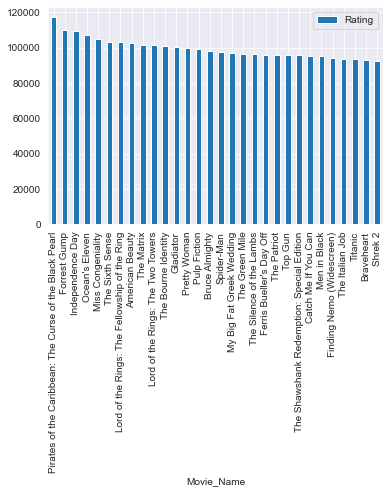

In [99]:
most_popular_fig.head(30).plot(kind="bar")

The bar graph above shows the most popular feature films in the dataset and these would also be clubed in the hybrid system

## Collaberative Filtering (Not Model Based) 

In [106]:
reader = Reader(rating_scale=(1, 5))
data

In [107]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [109]:
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [110]:
test_pred = algo.test(testset)
test_pred

[Prediction(uid=2517669, iid=28, r_ui=4.0, est=3.6046285714285715, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=2629402, iid=28, r_ui=5.0, est=3.6046285714285715, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=890968, iid=8, r_ui=2.0, est=3.6046285714285715, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=846883, iid=28, r_ui=4.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=1390512, iid=30, r_ui=5.0, est=3.6046285714285715, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=1524021, iid=28, r_ui=3.0, est=3.6046285714285715, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=1036360, iid=28, r_ui=4.0, est=3.6046285714285715, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=922375, iid=30, r_ui=3

In [111]:
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.0878


1.0877887190365283

## Collaborative Filtering (Item-Item Approach )

Here we find similarities between items to make suggestions/recommendations for the user. For that we would blend the idea of correlation and we use "Pearson's R"

In [112]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [113]:
recommend("Forrest Gump", 0)

For movie (Forrest Gump)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                 Name   count      mean
 1.000000                         Forrest Gump  181508  4.299910
 0.349910                             Rain Man  122158  4.125280
 0.346576                       The Green Mile  181426  4.306941
 0.336935                            Cast Away   87658  3.750781
 0.335988  Dances With Wolves: Special Edition   70799  3.943968
 0.323751                       Mrs. Doubtfire   68615  3.665248
 0.321019                  Saving Private Ryan  131175  4.295087
 0.319629                        Jerry Maguire   99460  3.804193
 0.316388                                Ghost  135431  3.649246
 0.314385                                  Big  114043  3.892444


Here we can see that when we try to recommend movies based on 'Forrest Gump', we could see more movies of TOM HANKS. This suggest that our model is working pretty fine

In [114]:
recommend("Lord of the Rings: The Fellowship of the Ring", 0)

For movie (Lord of the Rings: The Fellowship of the Ring)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                                                 Name   count      mean
 1.000000                        Lord of the Rings: The Fellowship of the Ring  149866  4.434708
 0.809049                                    Lord of the Rings: The Two Towers  151245  4.460676
 0.756614                            Lord of the Rings: The Return of the King  134284  4.545121
 0.691485  The Lord of the Rings: The Fellowship of the Ring: Extended Edition   73422  4.716611
 0.657337                  Lord of the Rings: The Two Towers: Extended Edition   74912  4.702611
 0.631096          Lord of the Rings: The Return of the King: Extended Edition   73335  4.723270
 0.454500                    Lord of the Rings: The Two Towers: Bonus Material    2127  4.213916
 0.298714         National Geographic: Beyond the Movie: The Lord of the Rings    2816  3.393821
 0.278

Again outhere, we requested recommendations considering "Lord of the Rings: The Fellowship of the Ring" and its sequel is been displayed atfirst, Another good sign.

In [117]:
recommend('Casino Royale',0)

For movie (Casino Royale)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                        Name  count      mean
 1.000000                               Casino Royale   3222  2.891993
 0.598991                                    The Deal   2061  2.727317
 0.592919                               Touch of Pink   2866  3.492673
 0.573458                                  Foxy Brown   1951  3.303434
 0.568798                                       Belly   2072  3.524131
 0.567210  Amandla! A Revolution in Four Part Harmony   2235  3.551678
 0.563610                         Outlaw Star: Vol. 2   2083  4.122420
 0.563555                           Disappearing Acts   3019  3.525340
 0.548718                  I Can Do Bad All By Myself   3637  3.741545
 0.535827                                      Blast!   2124  3.020245


In [118]:
recommend('Spider-Man 2',0)

For movie (Spider-Man 2)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                                   Name   count      mean
 1.000000                                           Spider-Man 2  136461  3.905768
 0.586785                                             Spider-Man  132142  3.871517
 0.378049                                       X2: X-Men United   98720  3.932202
 0.363778                                          Batman Begins   54922  4.236699
 0.352700                           Batman & Mr. Freeze: Subzero    3024  3.130952
 0.351001                                                  X-Men   99304  3.891223
 0.335885                        Dragon Ball Z: Super Android 13    2426  3.428689
 0.321205  Batman: The Animated Series: Tales of the Dark Knight    2432  3.583059
 0.314322                                                      I  155714  3.716461
 0.312837                                        The Incredibles  133457  4.308871

Thank You... :-)
